In [1]:
import sys
sys.path.insert(1, '../')
sys.path.insert(1, '../../')
import numpy as np
import matplotlib.pyplot as plt
from util.coil import *
from util.mask import *
from util.fft import *
import util.simulator as simulate
from util.phantom import * 
from util.rank import *
import util.io as io
import random

In [2]:
def convert_to_ndarray(files):
    ny, nx = files[0].shape
    cleaned_file = []
    for file in files:
        if file.shape == (ny,nx):
            cleaned_file.append(file)
        else:
            file = file[...,0]
            cleaned_file.append(file)
    ns = len(cleaned_file)
    output = np.zeros([ny, nx, ns], dtype = files[0].dtype)
    for sli, file in enumerate (cleaned_file):
        output[...,sli] = file
    return output

In [3]:
def low_rank_approx_kernel(data, k):
    [ny, nx, ns] = data.shape
    mat = np.zeros([k * k * k,(ns-k+1)*(ny-k+1)*(nx-k+1)], dtype = complex)
    idx = 0
    for s in range(max(1, ns - k + 1)):
        for y in range(max(1, ny - k + 1)):
            for x in range(max(1, nx - k + 1)):
                mat[:,idx] = data[y:y+k, x:x+k,s:s+k].reshape(1,-1)
                idx += 1
    return mat

In [4]:
def difference_operator(images):
    ny, nx, ns = images.shape
    out = np.zeros([ny, nx, ns-1])
    for sli in range(1, ns):
        out[...,sli-1] = images[...,sli] - images[...,sli-1]
    return out
        

In [5]:
def low_rank_approx_image(data):
    [ny, nx, ns] = data.shape
    mat = data.reshape(ny*nx,ns)
    return mat

In [82]:
import imageio
gif = imageio.get_reader("sample64_gt.gif", '.gif')

ns = len(gif)
images = []
for f in gif:
    images.append(f)
realimage = convert_to_ndarray(images)[:,:,:32]
import imageio
gif = imageio.get_reader("sample64-2345-wInit.gif", '.gif')
ns = len(gif)
images = []
for f in gif:
    images.append(f)
fakeimage = convert_to_ndarray(images)[:,:,:32]
gif = imageio.get_reader("sample64-3490.gif", '.gif')

ns = len(gif)
images = []
for f in gif:
    images.append(f)
fake2image = convert_to_ndarray(images)[:,:,:32]

In [87]:
slider(realimage)

interactive(children=(FloatSlider(value=0.0, description='idx', max=31.0, step=1.0), Output()), _dom_classes=(…

In [6]:
test = np.copy(realimage)
test[realimage < np.mean(realimage)] = 0
showc(difference_operator(test)[...,2])

NameError: name 'realimage' is not defined

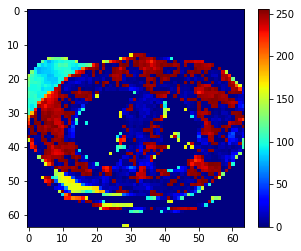

In [85]:
test1 = np.copy(fakeimage)
test1[fakeimage < np.mean(fakeimage)] = 0
showc(difference_operator(test1)[...,0])

In [55]:
np.mean(np.abs(test1))

70.40885925292969

In [12]:
def inspect_rank(data):
    U, S, VT = np.linalg.svd(data,full_matrices=False)
    S = S/np.max(S)
    print(S[1:].sum())
    S = np.diag(S)
    plt.figure(figsize=(8, 6), dpi=80)
    plt.subplot(2,1,1)
    plt.plot(np.diag(S)/np.max(np.diag(S)))
    plt.title('Singular Values')
    plt.subplot(2,1,2)
    plt.imshow(np.abs(np.transpose(VT)),aspect='auto', cmap = "jet")
    plt.show()

In [28]:
fakeimage = difference_operator(fakeimage)
slider(fakeimage)

interactive(children=(FloatSlider(value=0.0, description='idx', max=31.0, step=1.0), Output()), _dom_classes=(…

In [29]:
realimage = difference_operator(realimage)
slider(realimage)

interactive(children=(FloatSlider(value=0.0, description='idx', max=31.0, step=1.0), Output()), _dom_classes=(…

[1.         0.0849653  0.04425873 0.03404202 0.02455624 0.02312432
 0.02118324 0.01764995 0.01667949 0.01541333 0.01517699 0.0137667
 0.01267991 0.01264826 0.01215191 0.0118618  0.01162674 0.0115213
 0.01123041 0.01109387 0.01064459 0.01040352 0.0102266  0.00999668
 0.00947764 0.00942923 0.0092762  0.00919292 0.00905095 0.00876186
 0.00868458 0.00830656]
0.5190818367789041


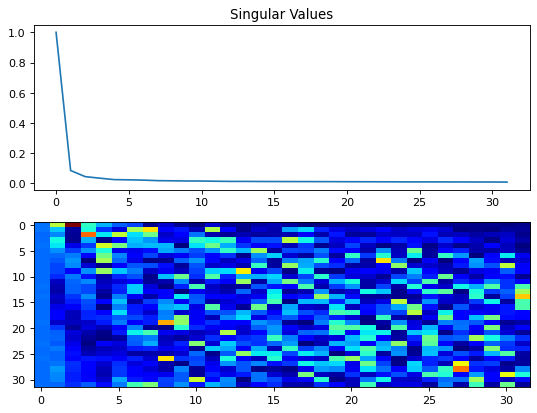

[1.00000000e+00 4.40386264e-02 1.76632258e-02 1.00949530e-02
 7.40727424e-03 5.42364100e-03 4.01948569e-03 3.06606421e-03
 2.32267301e-03 2.04563639e-03 1.67286465e-03 1.48119039e-03
 1.37905860e-03 1.26644745e-03 1.19909982e-03 1.16260720e-03
 1.14541815e-03 1.12352407e-03 1.11800415e-03 1.10943442e-03
 1.08340690e-03 1.08154483e-03 1.07860474e-03 1.07098119e-03
 1.05650405e-03 1.04634932e-03 1.04069365e-03 1.03791668e-03
 1.02101140e-03 1.01436974e-03 9.83370630e-04 9.60861898e-04]
0.12121484358296632


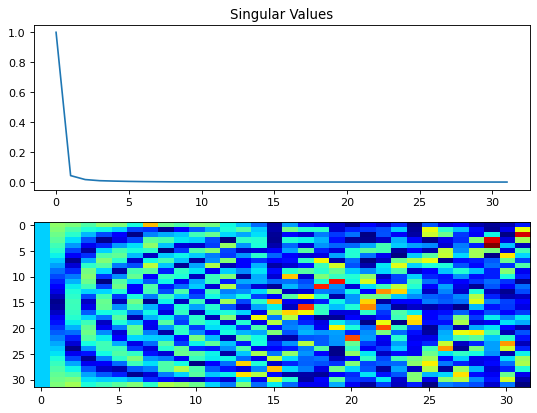

[1.         0.06758369 0.03126427 0.02093198 0.0147217  0.01027654
 0.00859908 0.00768043 0.00737737 0.0064219  0.00595171 0.00570471
 0.00557895 0.00538939 0.00506887 0.00490729 0.00480981 0.00464982
 0.00450341 0.0044162  0.00433802 0.00421691 0.00415081 0.00413063
 0.00402727 0.00398812 0.00395158 0.00385763 0.00378752 0.00374164
 0.00363589 0.00349277]
0.2731558990641421


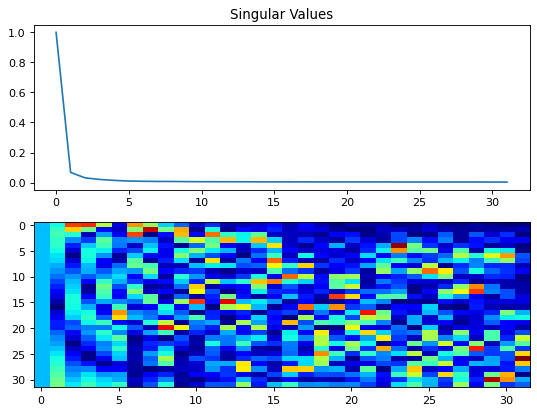

In [13]:
mat = low_rank_approx_image(fakeimage)
inspect_rank(mat)
mat = low_rank_approx_image(realimage)
inspect_rank(mat)
mat = low_rank_approx_image(fake2image)
inspect_rank(mat)

6.005095532511779


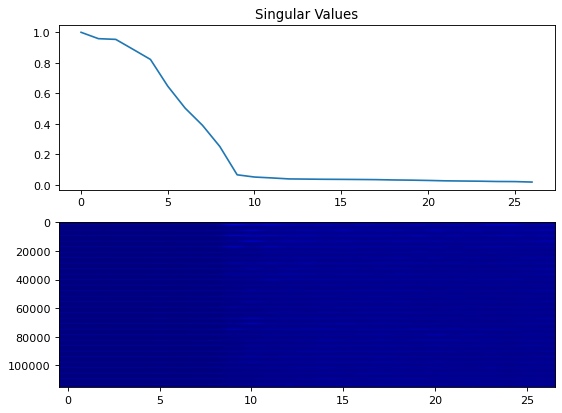

5.148770083740257


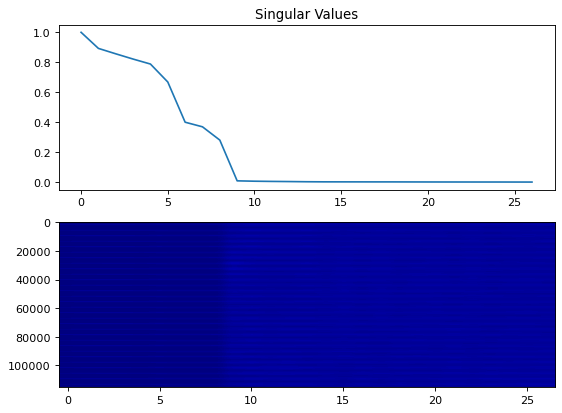

5.3355436118215485


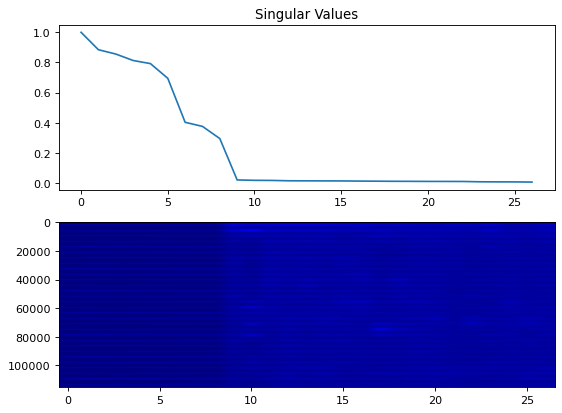

In [8]:
fakedata = fft2c(fakeimage)
mat = low_rank_approx_kernel(fakedata, 3)
inspect_rank(mat)
realdata = fft2c(realimage)
mat = low_rank_approx_kernel(realdata, 3)
inspect_rank(mat)
fake2data = fft2c(fake2image)
mat = low_rank_approx_kernel(fake2data, 3)
inspect_rank(mat)

In [9]:
def ifft3c(F, axis = (0,1,2)):
    x,y = (axis)
    tmp0 = np.fft.ifftshift(np.fft.ifftshift(F, axes=(x,)), axes=(y,))
    tmp1 = np.fft.ifft(np.fft.ifft(tmp0, axis = x), axis = y)
    f = np.fft.fftshift(np.fft.fftshift(tmp1, axes=(x,)), axes=(y,))
    return f * F.shape[x]* F.shape[y] * F.shape[z] 

def fft3c(f, axis = (0,1,2)):
    x,y,z = (axis)
    tmp0 = np.fft.fftshift(np.fft.fftshift(np.fft.fftshift(f, axes=(x,)), axes=(y,)), axes=(z,))
    tmp1 = np.fft.fft(np.fft.fft(np.fft.fft(tmp0, axis = x), axis = y), axis = z)
    F = np.fft.ifftshift(np.fft.ifftshift(np.fft.ifftshift(f, axes=(x,)), axes=(y,)), axes=(z,))
    return F / f.shape[x]/ f.shape[y]/ f.shape[z]

0.6818497399242357


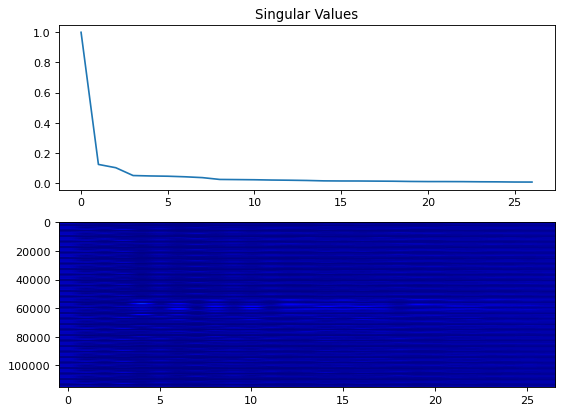

0.44718124399090337


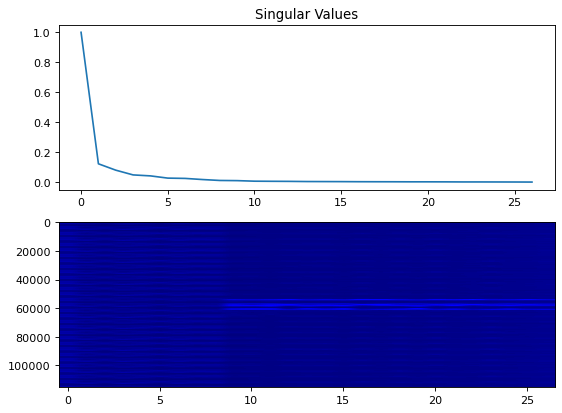

0.5097703849572858


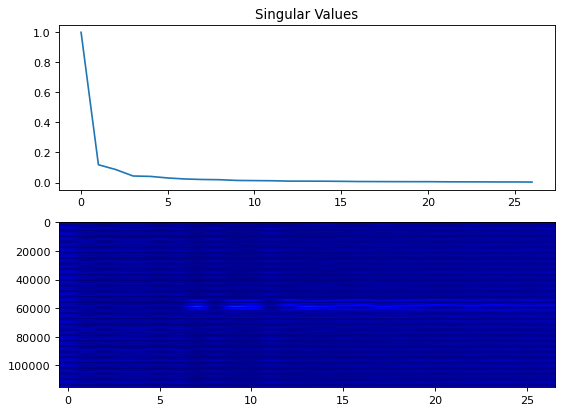

In [10]:
fakedata = fft3c(fakeimage)
mat = low_rank_approx_kernel(fakedata, 3)
inspect_rank(mat)
realdata = fft3c(realimage)
mat = low_rank_approx_kernel(realdata, 3)
inspect_rank(mat)
fake2data = fft3c(fake2image)
mat = low_rank_approx_kernel(fake2data, 3)
inspect_rank(mat)